In [2]:
import geopandas as gpd
import ee, eemont, geemap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Map = geemap.Map(center = [-33.9628184, 117.5364922], zoom = 4)


In [3]:
try:
    fire_history_19_20 = gpd.read_file('fire_history_19_20/fire_history_19_20.shp')
except:
    fire_history = gpd.read_file('fire_history/fire_history.shp')
    fire_history_19_20 = fire_history[fire_history['fih_fire_s'] == '2019/2020']
    fire_history_19_20.to_file('fire_history_19_20/fire_history_19_20.shp')
    fire_history_19_20 = gpd.read_file('fire_history_19_20/fire_history_19_20.shp')


In [33]:
fire_history_19_20.fih_hectar.mean()

1513.4614044478246

<AxesSubplot:>

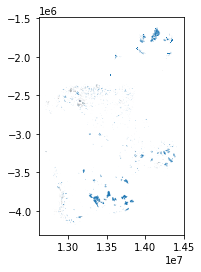

In [4]:
fire_history_19_20.plot()

In [29]:
fire_history_19_20

,fih_fire_s,fih_year1,fih_season,fih_distri,fih_hist_d,fih_number,fih_fire_t,fih_date1,fih_cause,fih_ignit_,...,fih_poly_t,fih_commen,fih_name,fih_burn_p,fih_master,fih_perime,fih_hectar,Shape_Leng,Shape_Area,geometry
0,2019/2020,2020,AU,BWD,Blackwood,BF 2019 BWD 038,WF,2020-02-26,7,0,...,Actual Burnt,"DFES No. 468486, Lightning strike reported thr...",Locke NR,0,0,0.111960,0.099493,134.697819,1.440135e+03,"POLYGON ((12826960.383 -3984386.955, 12826964...."
1,2019/2020,2020,AU,SWC,Swan Coastal,BF 2019 SWC 098,WF,2020-02-26,7,0,...,Actual Burnt,"DFES No. 468478, Likely Lighting strike fire n...",Panorama Dr Preston Beach,0,0,0.111959,0.099493,133.405120,1.412625e+03,"POLYGON ((12876396.017 -3871063.533, 12876399...."
2,2019/2020,2020,AU,BWD,Blackwood,BF 2019 BWD 039,WF,2020-02-26,7,0,...,Actual Burnt,"DFES No. 468491, Lightning strike",Treeton North Rd,0,0,0.354294,0.997660,427.058304,1.449612e+04,"POLYGON ((12816885.340 -4006414.447, 12816893...."
3,2019/2020,2020,AU,BWD,Blackwood,BF 2019 BWD 040,WF,2020-02-26,7,0,...,Actual Burnt,"DFES No. 468493, Lightning strike",Quindalup Siding,0,0,0.111960,0.099493,134.651593,1.439147e+03,"POLYGON ((12819298.623 -3980486.479, 12819302...."
4,2019/2020,2020,AU,BWD,Blackwood,BF 2019 BWD 041,WF,2020-02-26,7,0,...,Actual Burnt,"DFES No. 468496, Lightning strike",Bunker Bay Rd,0,0,0.111960,0.099493,134.517717,1.436287e+03,"POLYGON ((12805612.606 -3968844.779, 12805616...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066,2019/2020,2019,SP,GLD,Goldfields,999,999,2019-11-14,999,999,...,Actual Burnt,"Funded by GVDBT, Image dates: 2019-11-14 and 0...",None,999,0,17.857939,216.324892,20141.672611,2.747592e+06,"POLYGON ((14191976.421 -3155369.032, 14191875...."
3067,2019/2020,2019,SP,GLD,Goldfields,999,999,2019-11-14,999,999,...,Actual Burnt,"Funded by GVDBT, Image dates: 2019-11-14 and 0...",None,999,0,1.197249,3.505693,1360.738207,4.520379e+04,"POLYGON ((14035300.036 -3259143.016, 14035301...."
3068,2019/2020,2019,SP,GLD,Goldfields,999,999,2019-11-07,999,999,...,Actual Burnt,"Funded by GVDBT, Image dates: 2019-11-07 and 0...",None,999,0,1.322547,4.593619,1501.687895,5.932024e+04,"POLYGON ((14385618.863 -3269329.092, 14385618...."
3069,2019/2020,2019,SP,GLD,Goldfields,999,999,2019-11-14,999,999,...,Actual Burnt,"Funded by GVDBT, Image dates: 2019-11-14 and 0...",None,999,0,1.559585,6.481927,1772.350654,8.367522e+04,"POLYGON ((14198704.714 -3266776.291, 14198703...."


In [42]:
def get_index_frame(shapefile, collection):
 
    tbls = []
    
    gdf = shapefile.explode().to_crs('EPSG:4326')
 
    for index, gdf_row in gdf.iterrows():
 
        features = []
        
        geom = gdf_row.geometry 
        x, y = geom.exterior.coords.xy
        coords = np.dstack((x,y)).tolist()
        ee_geom = ee.Geometry.Polygon(coords)          
        feature = ee.Feature(ee_geom)
 
        features.append(feature)
                
        ee_fc = ee.FeatureCollection(features)
 
        peak_winter = '2019-07-31'
        fire_date = gdf_row.fih_date1
        #peak_winter_nxy = '2020-06-30'
 
        ee_col = (ee.ImageCollection(collection)
            .filterBounds(ee_fc)
            .filterDate(peak_winter, fire_date)
            .index(['NDVI']))
 
        ts = ee_col.getTimeSeriesByRegion(reducer = ee.Reducer.mean(),
                                          geometry = ee_fc,
                                          bands = ['NDVI'],
                                          scale = 250,
                                          dateFormat = 'YYYY-MM-dd')
 
        ts_pandas = geemap.ee_to_pandas(ts)
        ts_pandas[ts_pandas == -9999] = np.nan
        ts_pandas['date'] = pd.to_datetime(ts_pandas['date'],
                                           infer_datetime_format = True)
 
        ts_pandas['fire_id'] = gdf_row.fih_number
 
        tbls.append(ts_pandas)
 
    final_table = pd.concat(tbls)
    
    return final_table


In [43]:
# MCD43A4.006 MODIS Nadir BRDF-Adjusted Reflectance Daily 500m 
 
fire_data = get_index_frame(fire_history_19_20.head(10), "MODIS/006/MCD43A4")

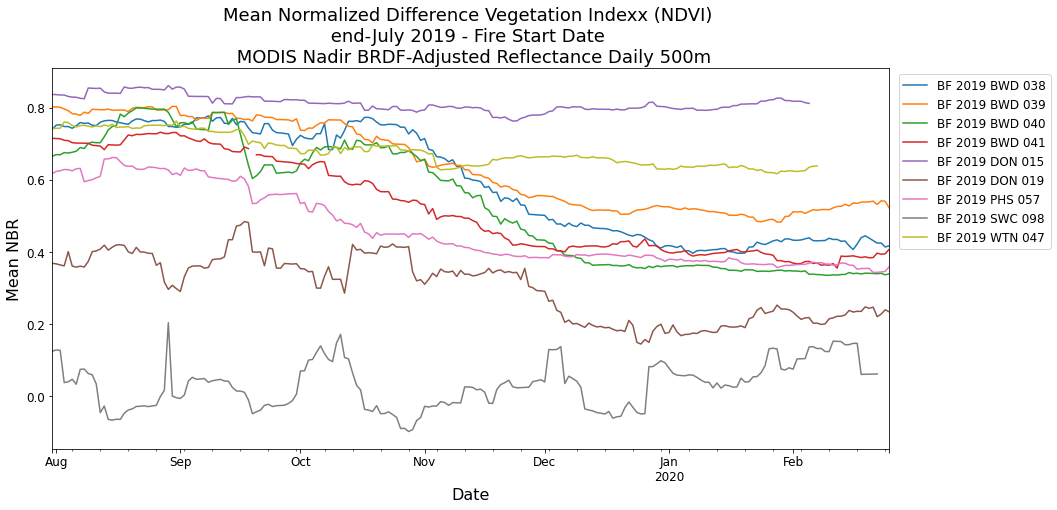

In [44]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,7),  constrained_layout = False)
 
for label, grp in fire_data.groupby('fire_id'):
    grp.plot(x = 'date',
             y = 'NDVI',
             ax = ax1,
             label = label,
             style = '-',
             markersize = 12)
 
# Set up formatting for graph 
 
ax1.set_xlabel('Date', fontsize=16)
ax1.set_ylabel('Mean NBR', fontsize=16)
ax1.set_title('Mean Normalized Difference Vegetation Indexx (NDVI) \n end-July 2019 - Fire Start Date  \n MODIS Nadir BRDF-Adjusted Reflectance Daily 500m', 
              fontsize = 18)
 
ax1.legend(fontsize = 12, loc = 'upper right', bbox_to_anchor=(1.2, 1))
 
ax1.tick_params(axis = 'both',
                which = 'major', 
                labelsize = 12)
